# model_v5

En el "model_v5", se entrena una red neuronal por medio de __Transfer Learning__.

Red neuronal base: 'imagenet'.

Con epoch: 5 > __Recall__: 50,4%

In [1]:
# Funciones
# ================================================================================================================================
import os, sys
sys.path.insert(1, r'C:\Users\gonza\OneDrive\Escritorio\Bootcamp_DS\Alumno\ds_thebridge_1_22\3-Machine_Learning\Entregas\utils')
from funciones import procesamiento_de_datos_X, procesamiento_de_datos_y, define_x_y
from funciones import plot_cm, metricas, plot_roc_curve

# Tratamiento de datos
# ==============================================================================
import os
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Tratamiento de imágenes
# ==============================================================================
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.models import Sequential

# Evaluación del modelo
# ==============================================================================
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 1. Procesamiento de datos
==================================================================================================

In [2]:
path_train = '../data/processed/train'
path_val = '../data/processed/val'
path_test = '../data/processed/test'
tipos = os.listdir(path_train)

In [3]:
# Definimos variables
X_train, y_train = define_x_y(path_train)
X_val, y_val = define_x_y(path_val)
X_test, y_test = define_x_y(path_test)

In [4]:
# Procesamiento de datos
X_train, X_val, X_test = procesamiento_de_datos_X(X_train, X_val, X_test)
y_train, y_val, y_test = procesamiento_de_datos_y(y_train, y_val, y_test)

# 2. Definición del modelo
==================================================================================================

## Transfer Learning

Vamos a utilizar como capa de entrada una red neuronal ya entrenada previamente por expertos, disponibles al público en __[TensorFlow Hub](https://tfhub.dev/)__, y exclusivamente relacionados con diagnóstico de enfermedades en plantas.

In [5]:
# TRANSFER LEARNING: Vamos a utilizar como primeras capas una red neuronal ya entrenada previamente por expertos

model = Sequential(
    [hub.KerasLayer("https://tfhub.dev/google/cropnet/feature_vector/imagenet/1",
                   trainable=False),
    tf.keras.layers.Dense(len(tipos), activation='softmax')
    ])

In [6]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenamiento del modelo
==================================================================================================

In [7]:
# fit the model
model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=128, 
                    verbose=2, 
                    # class_weight=class_weights
                    )

Epoch 1/5
27/27 - 60s - loss: 43.5517 - accuracy: 0.3527 - 60s/epoch - 2s/step
Epoch 2/5
27/27 - 58s - loss: 21.9845 - accuracy: 0.4238 - 58s/epoch - 2s/step
Epoch 3/5
27/27 - 63s - loss: 16.2382 - accuracy: 0.4639 - 63s/epoch - 2s/step
Epoch 4/5
27/27 - 82s - loss: 13.2771 - accuracy: 0.4925 - 82s/epoch - 3s/step
Epoch 5/5
27/27 - 73s - loss: 8.2517 - accuracy: 0.5227 - 73s/epoch - 3s/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5507432   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 5,512,556
Trainable params: 5,124
Non-trainable params: 5,507,432
_________________________________________________________________


### Guardamos el modelo

In [9]:
# Vamos a guardar nuestro modelo
if '../model/model_v5' not in os.listdir():
    model.save('../model/model_v5')

INFO:tensorflow:Assets written to: ../model/model_v5\assets


INFO:tensorflow:Assets written to: ../model/model_v5\assets


In [10]:
# Lo podemos llamar cuando queramos
reconstructed_model = keras.models.load_model('../model/model_v5')

# 4. Evaluación del modelo
==================================================================================================

In [11]:
metricas(y_test, reconstructed_model.predict(X_test))

Accuracy: 0.504
Precision: 0.492
Recall: 0.504


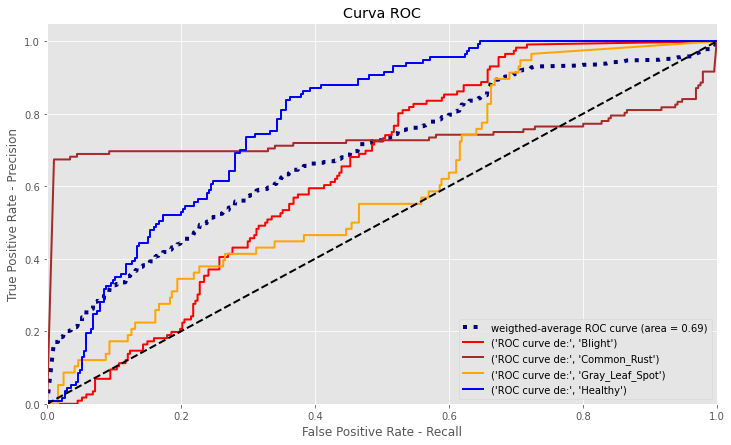

In [12]:
plot_roc_curve(y_test, reconstructed_model.predict(X_test))

In [13]:
# De un vistazo, matriz de confusión
cm = confusion_matrix(y_test, np.argmax(reconstructed_model.predict(X_test), axis=1))
cm_dec = [ cm[i] / np.sum(cm[i]) for i in range(len(cm))]
cm_per = [ [ str(round(x*100,1))+"%" for x in my_list] for my_list in cm_dec ]
cm_per

[['44.0%', '17.2%', '8.6%', '30.2%'],
 ['22.0%', '69.7%', '4.5%', '3.8%'],
 ['41.4%', '19.0%', '15.5%', '24.1%'],
 ['21.4%', '14.5%', '12.0%', '52.1%']]

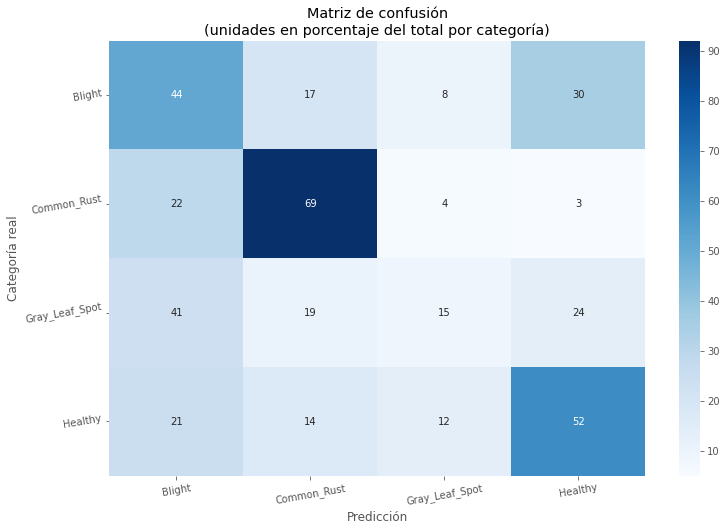

In [14]:
plot_cm(y_test, np.argmax(reconstructed_model.predict(X_test),axis=1))